# Week 7: Text representations

The purpose of this exercise is to get familiar with text representations. In the first part of the exercise, you will implement a text representation known as a **bag of words**-model. This will enable us to analyze large collections of text documents, also known as text corpora, using some of the standard tools from our machine learning and AI toolbox. Noticeably, you will apply singular value decomposition (SVD) to the bag-of-words vector space representation of a small text corpus. This results in a method known as **latent semantics analysis**.

This latent space will be useful for solving several different tasks related to text, such as **semantic analysis**, **document retrieval**, and **topic modelling**. You will see that we can use the latent semantic space obtained from a corpus of articles from the New York Times to solved the socalled "odd-one-out"-problems.

Finally, you will apply **sentiment analysis** to a large corpus of Amazon product reviews to figure out if a given customer liked the product based on their review.



In [24]:
from gensim.parsing import remove_stopwords
%matplotlib inline
import pylab as plt
import seaborn as snb
import numpy as np
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
snb.set_style('darkgrid')

# Exercise 1: Bag-of-word Representation and Latent Semantic Analysis

## Analyzing the titles of scientific papers

The code below defines a small text corpus consisting of headlines from scientific papers. We will refer to the element in the corpus as **documents**, i.e. here we consider each headline as a (short) document.  Hence, this corpus consists of six documents.

The goal of this exercise is to apply latent semantic analysis to these documents to extract the semantics.


In [25]:
documents = ['Analysis of EEG Signal for the Detection of Brain Abnormalities',
             'EEG source imaging assists decoding in a face recognition task',
             'Brain Source Localization Using EEG Signal Analysis',
             'Deep Neural Networks for Object Detection',
             'Imagenet classification with deep convolutional neural networks',
             'Very deep convolutional networks for large-scale image recognition']

num_doc = len(documents)

## 1: Basic string manipulation in python

However, before we can dive into the analysis, we need to process the data and learn how to handle text and strings in python. 

When dealing with text data and strings in python, the functions *join* and *split* are indispensable. The function *split* takes a string as input as splits it into a list of individual words, whereas the function *join* takes a list of words as input as concatenates them into a single string of words. 

**1. Spend a moment to look up these functions and make sure you understand how they work and how they are used in the small example below.**

In [26]:
s1 = 'This is a string'
s2 = s1.split()
s3 = ' '.join(s2)
s4 = '-'.join(s2)
s5 = s4.split()
s6 = s4.split('-')

print('s1:', s1)
print('s2:', s2)
print('s3:', s3)
print('s4:', s4)
print('s5:', s5)
print('s6:', s6)

s1: This is a string
s2: ['This', 'is', 'a', 'string']
s3: This is a string
s4: This-is-a-string
s5: ['This-is-a-string']
s6: ['This', 'is', 'a', 'string']


**$\star$ 2. Python has a useful module called re which can be very helpful in not only finding a substring in a string. Here is some basic usage.**

In [27]:
import re

text = "Analysing the semantics of latent semantic analysis is a semantically interesting task"
pattern = r"semantic"

matches = re.findall(pattern, text)
print(matches)

['semantic', 'semantic', 'semantic']


*We can also find the indexes:*

In [28]:
matches = re.finditer(pattern, text)

for match in matches:
    print(f"Match: {match.group()} at index: {match.start()}")

Match: semantic at index: 14
Match: semantic at index: 34
Match: semantic at index: 57


*And lastly here is a pythonic way of simply checking whether a substring is in another string:*

In [29]:
print(f"Is pattern in text? {pattern in text}")

Is pattern in text? True


## 2: Preprocessing and constructing the vocabulary

*First, we will simply convert all documents to lower-case letters and count the total number of words to get started.*

In [30]:
# lower case
documents = [doc.lower() for doc in documents]

# split documents into words and count
words = ' '.join(documents).split(' ')
num_words = len(words)

print('Number of documents:\t%d' % num_doc)
print('Number of words:\t%d' % num_words)


Number of documents:	6
Number of words:	48


*Next, we will make a list of all the unique words contained in the corpus. This list is known as the **vocabulary**. For our convenience, we will also sort the vocabulary.*

In [31]:
# determine the vocabulary
def get_vocabulary(words):
    ''' This function takes a list of words and return the vocabulary. That is, a sorted list of all the words that occur at least once in the documents.'''
    vocabulary = sorted(list(set(words)))
    return vocabulary

vocabulary = get_vocabulary(words)
vocab_size = len(vocabulary)

print('Vocabulary size:\t%d' % vocab_size)

print('\nWords in the vocabulary:')
print(23*'-')
for word in vocabulary:
    print(word)

Vocabulary size:	31

Words in the vocabulary:
-----------------------
a
abnormalities
analysis
assists
brain
classification
convolutional
decoding
deep
detection
eeg
face
for
image
imagenet
imaging
in
large-scale
localization
networks
neural
object
of
recognition
signal
source
task
the
using
very
with


### 3: Stop words; Not all words are informative

*Imagine we want to build a text classification system. In this context, it is clear that not all words are equally important. For example, words like 'a', 'for', 'in', 'with' etc. do not really contribute with any semantic content. That is, these words are more or less irrelevant for the content or message of the document. These words are known as **stop words** in the field of natural language processing (NLP). These words are usually ignored in a semantic analysis, and we will therefore remove them from our vocabulary.*

*For now, we consider the following list of stop words.*

**1. Add more words to this list that you also consider stop words:**

In [32]:
stop_words = ['the', 'of', 'in', 'via', 'for', 'a', 'with', 'to', 'and', 'very', 'using']
print('Number of stop words:\t%d' % len(stop_words))

Number of stop words:	11


*The following function removes the stop words from our vocabulary.*

In [33]:
def remove_stop_words(vocabulary, stop_words):
    ''' The function takes in a list of words (vocabulary) and a list of stop words and returns a new vocabulary, where all the stop words have been removed. '''
    return [word for word in vocabulary if word not in stop_words]


*Remove stop words from the vocabulary*

In [34]:
# remove stop words from vocabulary
vocabulary = remove_stop_words(vocabulary, stop_words)

# count number of words in vocabulary again
vocab_size = len(vocabulary)

print('Vocabulary size:\t%d' % vocab_size)

print('\nWords in the vocabulary:')
print(23*'-')
for word in vocabulary:
    print(word)

Vocabulary size:	23

Words in the vocabulary:
-----------------------
abnormalities
analysis
assists
brain
classification
convolutional
decoding
deep
detection
eeg
face
image
imagenet
imaging
large-scale
localization
networks
neural
object
recognition
signal
source
task


## 4: Constructing the bag-of-words representation

We are now ready to construct the bag-of-words representation for our small text corpus. The bag-of-words model is a matrix representation of a text corpus describes how many times a given word is present in a given document. Specifically, the bag-of-words matrix is a matrix $\mathbf{A}$, where the number of rows is equal to the number of words in the vocabulary and the number of columns is equal to the number of documents, i.e. $\mathbf{A} \in \mathbb{R}^{\text{Voculary size} \times \text{Number of documents}}$ . The element in the i'th row and j'th column describes how many times the i'th word in the vocabulary occurs in the j'th document, 

$A_{ij} = \text{Number of times the i'th word in the vocabulary occurs in the j'th document}.$

*It is common that each document only contains a small subset of the vocabulary words, and therefore the bag-of-words matrices are most often **sparse** meaning that each column contains mostly zeros.*


*The words in the vocabulary is sometimes also referred to as *terms* and the bag-of-words matrix is also referred to as the term-by-document matrix.*

**1. Inspect the following code that implements the function for constructing a bag-of-words representation based on a corpus of documents and its associated vocabulary and for your own sake ensure that you understand the code.**



*The code relies on a look-up table to find a given word's position in the vocabulary:  
       word2idx = {word: idx for idx, word in enumerate(vocabulary)}*
   
*You can check if a word is contained in the vocabulary using the **in** keyword. For example, the statement **'analysis' in vocabulary** returns true because the vocabulary contains the word 'analysis'. On the other hand, the statement **'bear' in vocabulary** returns false because the word 'bear' is not part of the vocabulary.*
   


In [35]:
def construct_bag_of_words(documents, vocabulary):
    '''
    This functions takes a list of documents and a vocabulary a returns the corresponding bag-of-words representation of the documents
    
    If the variable "document" is a list of N documents and the variable "vocabulary" is a list of M words, then the function should return a bag-of-words matrix A of size N x M matrix.
    If some word from a document is not present in the vocabulary, it should be ignored.
    '''
    
    num_doc = len(documents)
    vocab_size = len(vocabulary)
        
    # Make a word-to-idx mapping so each word can be mapped to a unique index
    word2idx = {word: idx for idx, word in enumerate(vocabulary)}
    
    # Create a matrix where rows are words and columns are documents
    bag_of_words = np.zeros((vocab_size, num_doc))
    
    # Enumerate over each document
    for idx_doc, doc in enumerate(documents):
        # And each word in document...
        for word in doc.split():
            if word in vocabulary:
                # ...increment the counter for that one word in a given document once (use word2idx to get a index based)
                bag_of_words[word2idx[word], idx_doc] += 1

    return bag_of_words
    

**2. The following code constructs the bag-of-words representation for the corpus containing titles of scientific papers.**

In [36]:
A = construct_bag_of_words(documents, vocabulary)       

# print bag of words matrix and along with the vocabulary
print(35*'-')
print('Bag of word matrix')
print(35*'-')
for vocab_word, A_row in zip(vocabulary, A):
    print('%-15s' % vocab_word, A_row)
    
# print documents
print('\n')
print(70*'-')
print('Documents')
print(70*'-')
for doc in documents:
    print(doc)

-----------------------------------
Bag of word matrix
-----------------------------------
abnormalities   [1. 0. 0. 0. 0. 0.]
analysis        [1. 0. 1. 0. 0. 0.]
assists         [0. 1. 0. 0. 0. 0.]
brain           [1. 0. 1. 0. 0. 0.]
classification  [0. 0. 0. 0. 1. 0.]
convolutional   [0. 0. 0. 0. 1. 1.]
decoding        [0. 1. 0. 0. 0. 0.]
deep            [0. 0. 0. 1. 1. 1.]
detection       [1. 0. 0. 1. 0. 0.]
eeg             [1. 1. 1. 0. 0. 0.]
face            [0. 1. 0. 0. 0. 0.]
image           [0. 0. 0. 0. 0. 1.]
imagenet        [0. 0. 0. 0. 1. 0.]
imaging         [0. 1. 0. 0. 0. 0.]
large-scale     [0. 0. 0. 0. 0. 1.]
localization    [0. 0. 1. 0. 0. 0.]
networks        [0. 0. 0. 1. 1. 1.]
neural          [0. 0. 0. 1. 1. 0.]
object          [0. 0. 0. 1. 0. 0.]
recognition     [0. 1. 0. 0. 0. 1.]
signal          [1. 0. 1. 0. 0. 0.]
source          [0. 1. 1. 0. 0. 0.]
task            [0. 1. 0. 0. 0. 0.]


----------------------------------------------------------------------
Document

### 5: Examine the bag-of-words representation

**1. Validate the bag-of-words matrix above by comparing it to the list of documents and the vocabulary**
*No solution other than looking through the code and documents.*
**2. Using our vocabulary, derive the vector representations of the following two sentences (documents) by hand:**
*Here we provide a solution to compare to, not the derivation by hand, sorry*
- "EEG Source localization assists face recognition"
- "Face recognition assists EEG Source localization"

In [41]:
sentence_1 = remove_stopwords("EEG Source localization assists face recognition").lower()
print(np.array([word in sentence_1 for word in vocabulary], dtype=float).reshape((-1, 1)))

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [42]:
sentence_2 = remove_stopwords("Face recognition assists EEG Source localization").lower()
print(np.array([word in sentence_2 for word in vocabulary], dtype=float).reshape((-1, 1)))

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]




**3. Explain which semantic structures of the text documents are preserved and which structures are lost using the bag-of-words representation?**
Preserved structures:
- Word frequency is retained, which helps capture the importance of each word within a document.
- Vocabulary presence (whether a word appears or not) is maintained.
Lost structures:
- Word order and context are completely disregarded.
- Grammar, syntax, and relationships between words are ignored.
- Semantics from the sequence of words (e.g., meaning derived from sentence structure) are lost.


## 6: The term-by-term and document-by-document matrices

*We will now construct the so-called term-by-term matrix, $\mathbf{B} = \mathbf{A}\mathbf{A}^T$, and document-by-document matrix, $\mathbf{C}=\mathbf{A}^T\mathbf{A}$. The $\mathbf{B}$ matrix is sometimes also known as the **co-occurence matrix**.*


**1. Explain why these names are appropriate for the matrices $\mathbf{B}$ and $\mathbf{C}$**
*Hint: What does an inner product between two vectors represent?*

POSSIBLE ANSWER: By looking at just dimensions alone, the A matrix is dimensions $\text{term} \times \text{docs}$, having the term by term (B) there is $\text{term} \times \text{term}$, while the doc by doc (C) is $\text{doc} \times \text{doc}$. In regards to the **Co-occurence matrix**, it comes from the fact that it lists how often thoes words appear together across all documents in the corpus


[[1. 0. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]


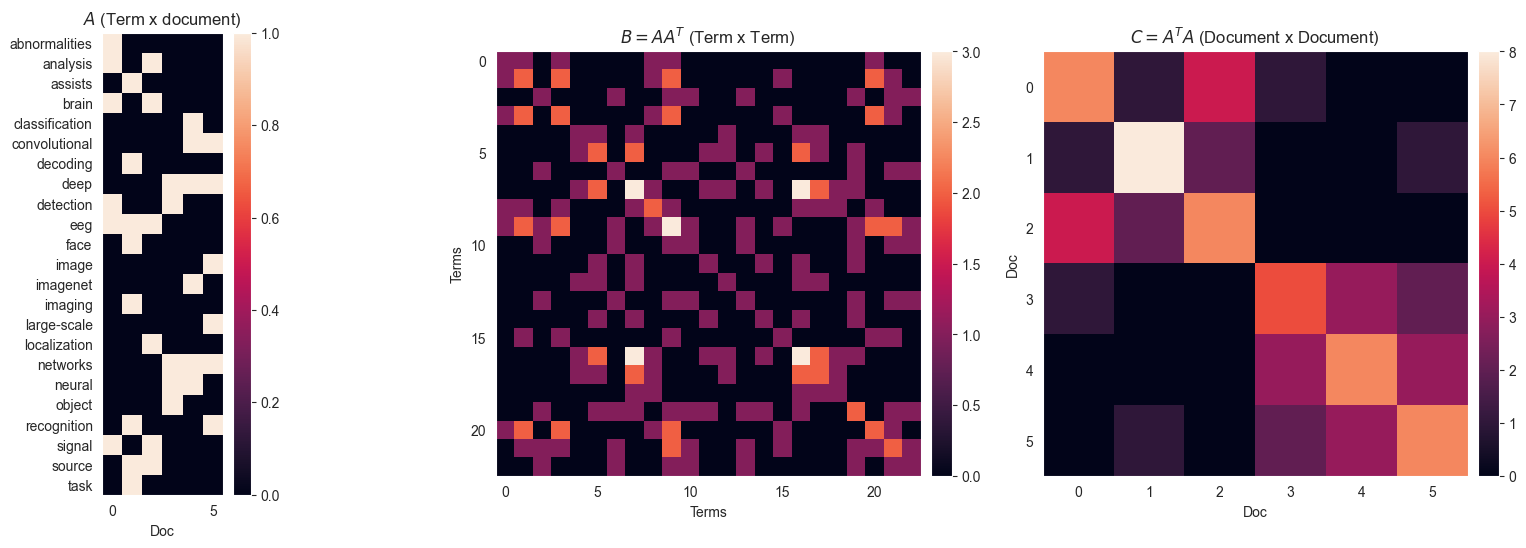

In [23]:
#compute the B and C matrix
print(A[:3,:3])
B = np.matmul(A, A.T) # Also possible to use A @ A.T
C = np.matmul(A.T, A) # Also possible to use A.T @ A

plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 3, 1)
im = plt.imshow(A)
plt.xlabel('Doc')
plt.yticks(np.arange(0, vocab_size), vocabulary)
plt.title('$A$ (Term x document)')
plt.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%", pad=0.1)
plt.colorbar(im, cax=cax)

ax = plt.subplot(1, 3, 2)
im = plt.imshow(B)
plt.xlabel('Terms')
plt.ylabel('Terms')
plt.title('$B = AA^T$ (Term x Term)')
plt.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

ax = plt.subplot(1, 3, 3)
im = plt.imshow(C)
plt.xlabel('Doc')
plt.ylabel('Doc')
plt.title('$C = A^T A$ (Document x Document)')
plt.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

**3. Inspect the plot of the matrix $\mathbf{A}$ to figure how many times the word "recognition" is present in the corpus.**

ANSWER: You can see this quite easily by simply counting the corresponding row in the Term X document matrix, in this case it is 2

**4. What is the interpretation of the diagonal of the term-by-term matrix $\mathbf{B}$?**

ANSWER: This would be how many times that specific term appears across all documents


**5. Inspect the plot of the matrix $\mathbf{A}$ again to figure how many words the first document contains.**

ANSWER: This can be done by counting the number of terms in a whole column, in this case the first. We get 6.

**6. What is the interpretation of the diagonal of the document-by-document matrix $\mathbf{C}$?**

ANSWER: This shows how many terms are present in that single document.

**7. What does it mean of an off-diagonal element in $C_{n,m}$, $n \neq m$ is zero?**
*Hint: The (n,m)'th element of $\mathbf{C}$ can be written as: $C_{nm} = \sum_{k} A_{kn} A_{km}$ and $A_{kn}$ is zero if the k'th word is not present in the m'th document*

ANSWER: It means that those two documents have no terms in common

## 6: Another interpretation of the matrices $B$ and $C$

If we consider each document as a separate observation, then the matrix $\mathbf{B}$ can be interpreted as the second moments of the documents and hence, the matrix $\mathbf{B}$ is closely related to the empirical covariance matrix $\mathbf{S}$ of the documents. This naturally suggests that we use principal component analysis (PCA) to understand the structure of the documents by decomposing the matrix $\mathbf{B}$ into eigenvectors and eigenvalues,

$\mathbf{B} = \mathbf{U}\Lambda  \mathbf{U}^\top$,

where $\mathbf{U}$ is a matrix of eigenvectors and $\Lambda$ is a diagonal matrix of eigenvalues.

Using a similar line of reasoning, we can decompose $\mathbf{C}$ as follows

$\mathbf{C} = \mathbf{V}\Lambda  \mathbf{V}^\top$.

It can be shown that the two matrices $\mathbf{B}$ and $\mathbf{C}$ share the same eigenvalues, so we only need one common $\Lambda$ matrix.

From $\mathbf{B}\mathbf{x} = \lambda \mathbf{x}$ we can obtain $\mathbf{C}\mathbf{z} = \lambda \mathbf{z}$ by using the definitions of $\mathbf{B}$ and $\mathbf{C}$.
That is, $\lambda$ is an eigenvalue of $\mathbf{C}$ corresponding to the eigenvector $\mathbf{A}^T \mathbf{x}$.


*(Optional) Technical note: Formally, the term-by-term matrix $\mathbf{B}$ is the second order moment of the documents and not the covariance matrix as typically used in principal component analysis. We could obtain the actual empirical covariance matrix from by substracting the outer product of the mean vectors, i.e. $\mathbf{S} = \mathbf{B} - \mathbf{m}\mathbf{m}^T$, where $\mathbf{m}$ is the mean document vector. However, we choose not to do this for computational reasons. Namely, the matrix $\mathbf{B}$ is sparse, meaning that most of the entries are equal to zero. This has the benefit that we can represent it very efficiently in our computers. In contrast, the covariance matrix $\mathbf{S}$ will in general not be sparse and hence, it is requires more memory to store the matrix. This does not make a big difference for the small example we consider here, but this can be prohibitive costly for real-world large-scale applications.  The same line of reasoning applies to the matrix $\mathbf{C}$.*

**1. Verify that the eigenvalues of the two matrices are indeed the same:**

In [18]:
def eigendecompose(X):
    ''' Return the eigendecomposition (E, V) of X s.t. eigenvalues are sorted descendingly '''
    lam, V = np.linalg.eigh(X)
    sort_idx = np.argsort(lam)[::-1]
    return lam[sort_idx], V[:, sort_idx]

lambdas_C, V = eigendecompose(C)
lambdas_B, U = eigendecompose(B)
# Pretty print with 4 decimal places
np.set_printoptions(precision=6, suppress=True)

# Print for lambdas_C
print("Eigenvalues of C:")
print(lambdas_C)
print("\n")

# Print for lambdas_B
print("Eigenvalues of B:")
print(lambdas_B)
print("\n")

# Print the difference between lambdas_C and the first 6 eigenvalues of B
print("Difference (lambdas_C - first 6 of lambdas_B):")
print(lambdas_C - lambdas_B[:len(lambdas_C)])

Eigenvalues of C:
[11.862584 10.636732  6.968732  3.380007  2.591737  1.560208]


Eigenvalues of B:
[11.862584 10.636732  6.968732  3.380007  2.591737  1.560208  0.
  0.        0.        0.        0.        0.        0.        0.
 -0.       -0.       -0.       -0.       -0.       -0.       -0.
 -0.       -0.      ]


Difference (lambdas_C - first 6 of lambdas_B):
[ 0.  0. -0.  0.  0. -0.]


## 7: Latent semantics analysis

Studying the latent spaces induced by the eigendecompositions above is known as **Latent Semantic Analysis (LSA)** or sometimes also known as **Latent Semantic Indexing (LSI)**. We will now project each document to the latent semantic space to analyze how the documents relate to each other. 

Recall that,

$\mathbf{A} = \mathbf{U}\Lambda^{\frac{1}{2}}  \mathbf{V}^T$

$\mathbf{B} = \mathbf{A}\mathbf{A}^\top = \mathbf{U}\Lambda^{\frac{1}{2}} \underbrace{\mathbf{V}^T    \mathbf{V}}_{\mathbb{I}_{M\times M}} \Lambda^{\frac{1}{2}} \mathbf{U}^\top = \mathbf{U}\Lambda \mathbf{U}^\top$

$\mathbf{C} = \mathbf{A}^\top\mathbf{A} = \mathbf{V}\Lambda^{\frac{1}{2}} \underbrace{\mathbf{U}^T    \mathbf{U}}_{\mathbb{I}_{N\times N}} \Lambda^{\frac{1}{2}} \mathbf{V}^\top = \mathbf{V}\Lambda \mathbf{V}^\top$

We can project each document in our corpus to the latent semantic space as follows

$\mathbf{z}_{\text{doc}} = \mathbf{\Lambda}_k^{-\frac12}\mathbf{U}_k^T \mathbf{A} = \mathbf{P}_k \mathbf{A}$

where $\mathbf{P}_k = \mathbf{\Lambda}_k^{-\frac12}\mathbf{U}_k^T $ acts as a projection matrix. 

$\mathbf{P}_k = \mathbf{\Lambda}_k^{-\frac12}\mathbf{U}_k^T$

For visualization purposes, we will focus on $k = 2$ dimensions for now.


In [19]:
# let's focus on the first two components for visualization purposes
k = 2
Uk = U[:, :k]
Lk = lambdas_C[:k]
Vk = V[:, :k]

**1. Project each document into the latent semantic space:**

In [20]:
# define projection matrix for the documents
P = np.diag(1./np.sqrt(Lk))@Uk.T

# project
z_doc = P@A

*Let's plot it and along with the document titles*

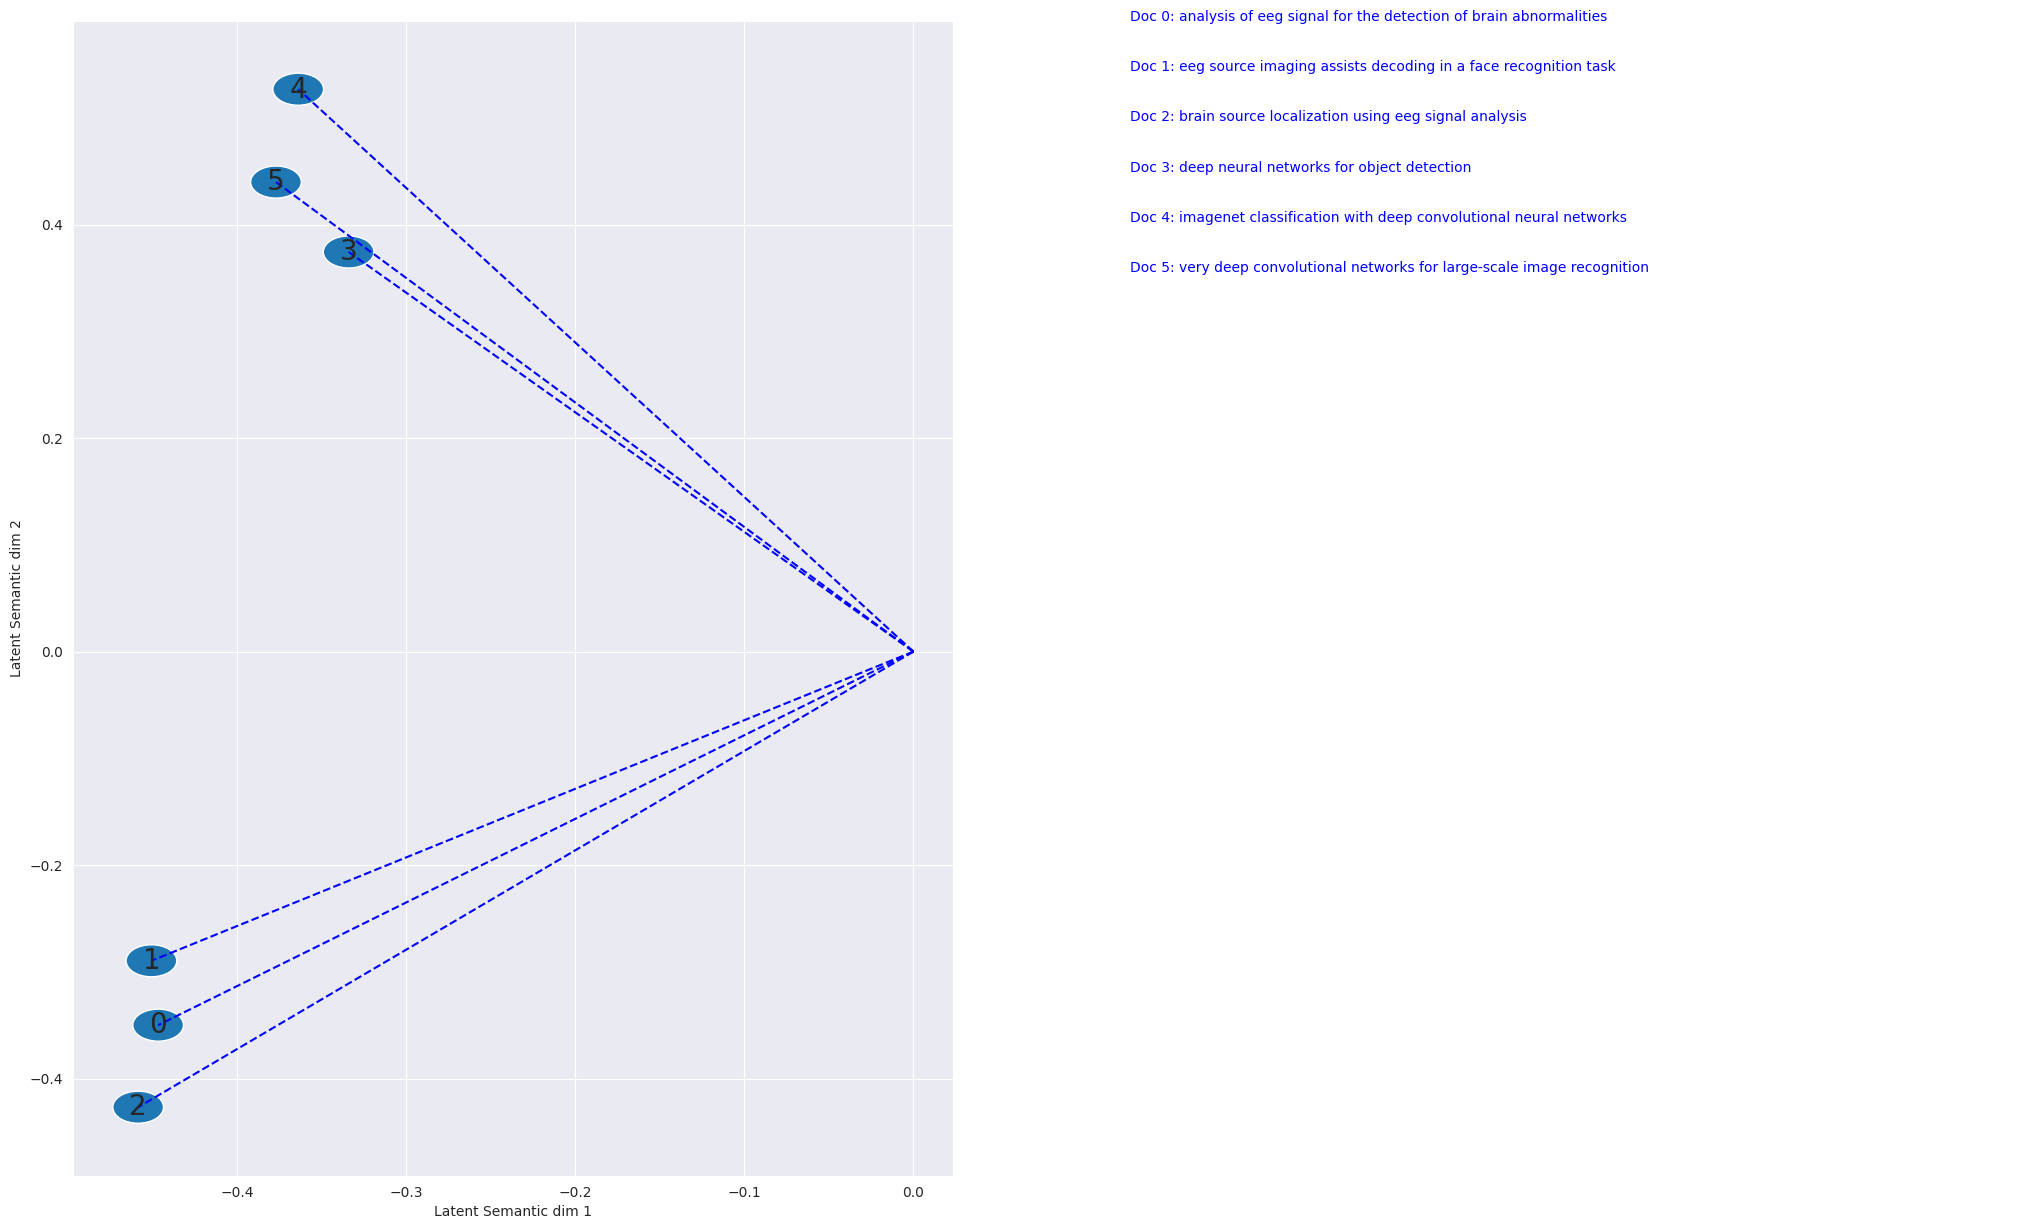

In [21]:
plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 2, 1)
for idx, doc in enumerate(z_doc.T):
    plt.plot([0, doc[0]], [0, doc[1]], 'b--')
    circle = plt.Circle((doc[0], doc[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(idx, xy=(doc[0], doc[1]), fontsize=20, ha="center", va="center")

plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')
    
plt.subplot(1, 2, 2)
plt.axis('off')
for idx, doc in enumerate(documents):
    i = idx
    plt.text(0, 1 - i/vocab_size, 'Doc %d: %s' % (i, doc), color='b')
    
    

*The dashed lines help to emphasise the angles between the vectors, which will be relevant when we use the cosine similarity metric later.*

**2. The above figure shows that the 6 documents form 2 clusters in the latent semantic space. Can you figure out what the papers in each cluster have in common?**

ANSWER: Cluster 0,1,2 is clearly about some EEG brainwave classification stuff, while Cluster 3,4,5 is more about CNN and image classification stuff.

### 8: Words can also be represented in the latent semantic space

We can also project each word in our vocabulary to a 2 dimensional latent semantic space as follows

$\mathbf{z}_{\text{word}} = \mathbf{A} \mathbf{V}_k  \mathbf{\Lambda}_k^{-\frac12} = \mathbf{A}  \mathbf{P}_k$

where $\mathbf{P}_k = \mathbf{V}_k  \mathbf{\Lambda}_k^{-\frac12}$ acts as a projection matrix. 


We will now project the words into the latent semantic space and visualize them along with the documents.

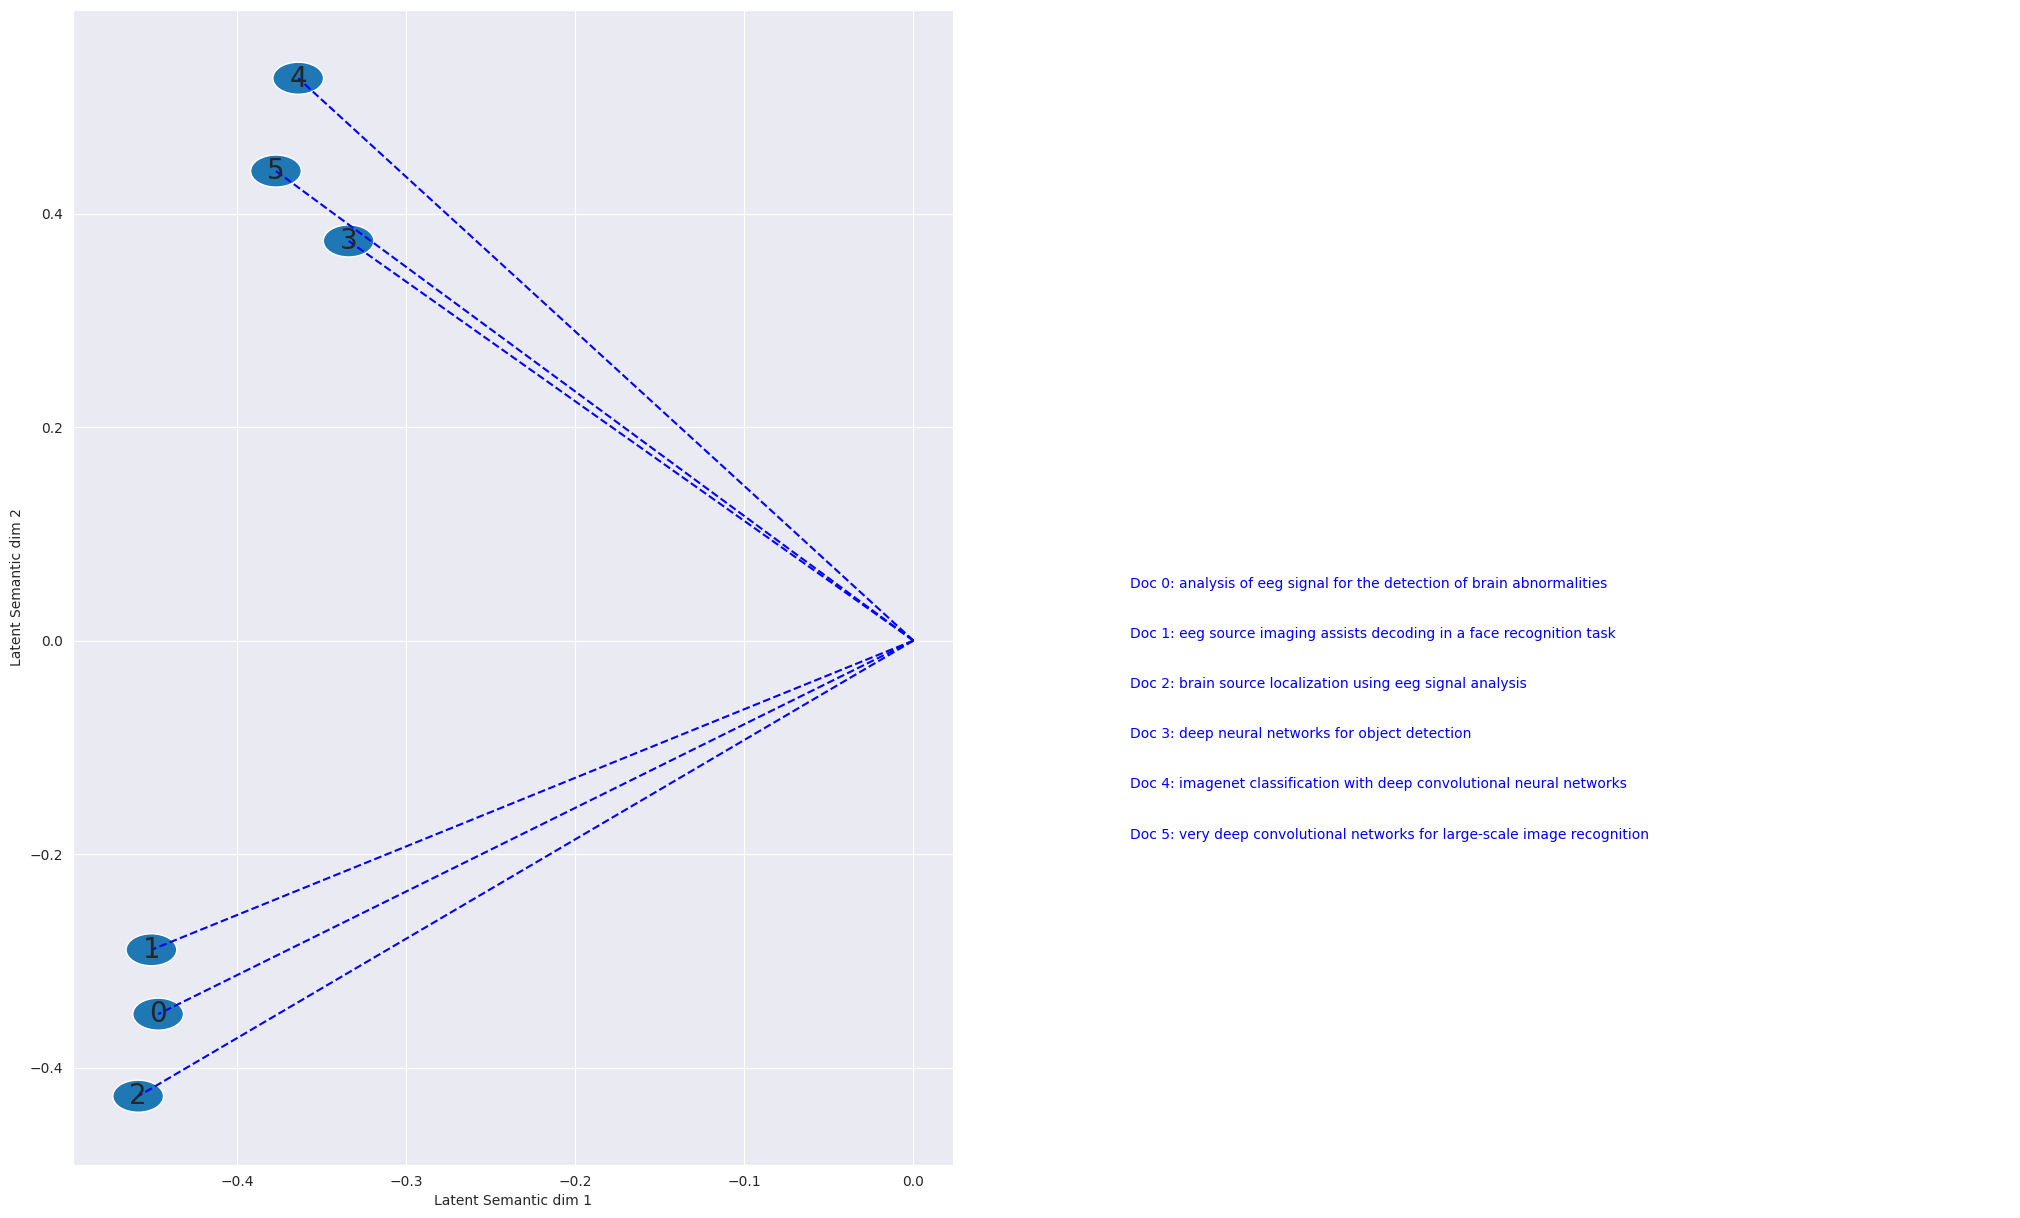

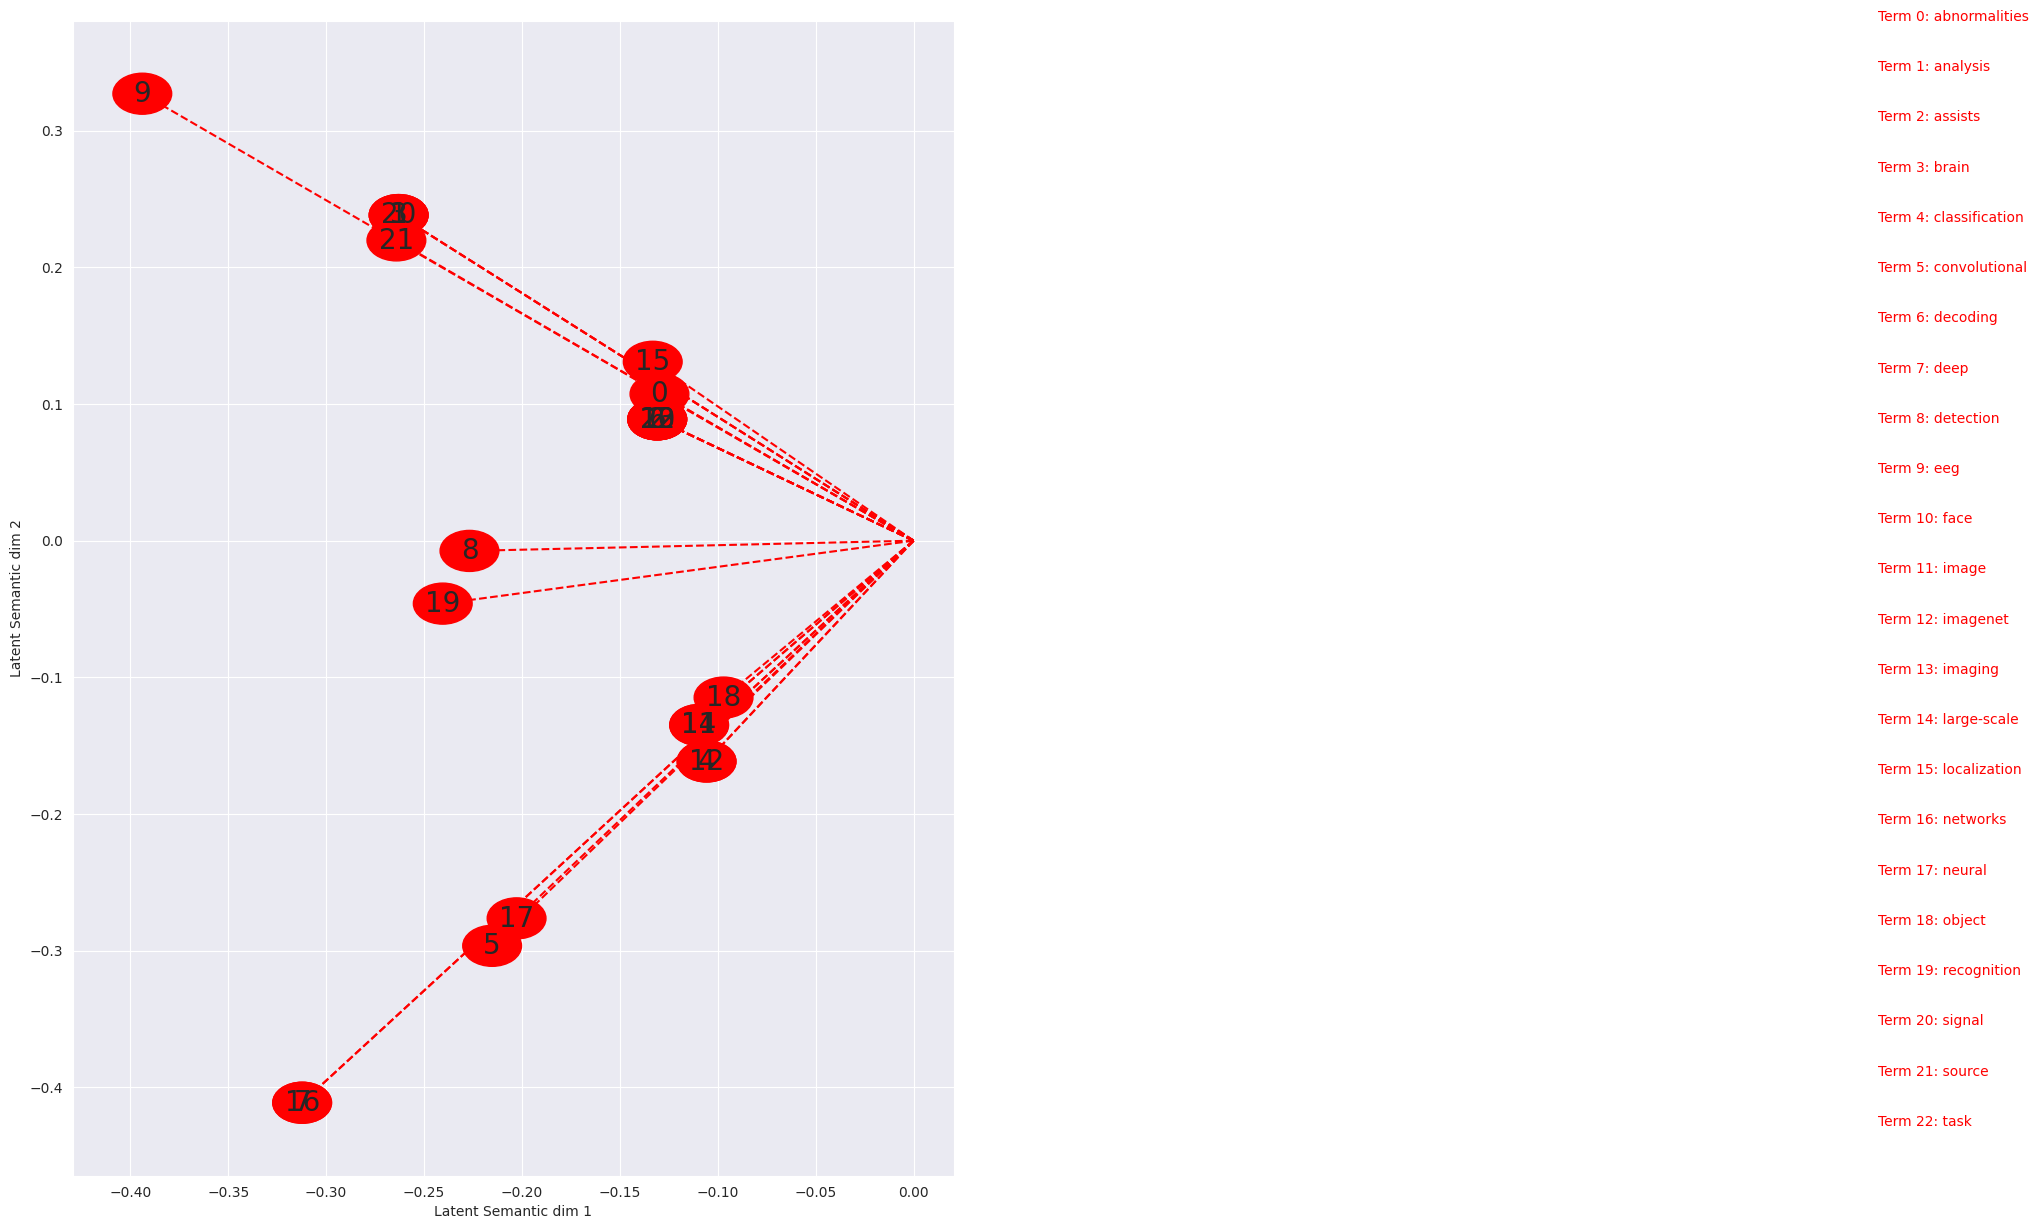

In [22]:
# define projection matrix for the words
P = Vk@np.diag(1./np.sqrt(Lk))

# project
z_word = A@P

plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 2, 1)
for idx, doc in enumerate(z_doc.T):
    plt.plot([0, doc[0]], [0, doc[1]], 'b--')
    circle = plt.Circle((doc[0], doc[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(idx, xy=(doc[0], doc[1]), fontsize=20, ha="center", va="center")
plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')

ax = plt.subplot(1, 2, 2)
plt.axis('off')
for idx, doc in enumerate(documents):
    i = idx
    plt.text(0, 0.5 - i/vocab_size, 'Doc %d: %s' % (i, doc), color='b')

plt.figure(figsize=(25, 15))

ax = plt.subplot(1, 2, 1)
for idx, term in enumerate(z_word):
    plt.plot([0, term[0]], [0, term[1]], 'r--')
    circle = plt.Circle((term[0], term[1]), radius=0.015, color='r')
    ax.add_patch(circle)
    label = ax.annotate(idx, xy=(term[0], term[1]), fontsize=20, ha="center", va="center")
    
plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')
    
ax = plt.subplot(1, 2, 2)
plt.axis('off')
for idx, term in enumerate(vocabulary):
    i = idx
    plt.text(0.85, 1 - i/vocab_size, 'Term %d: %s' % (i, term), color='r')
    

**1. Explain The clustering structure that emerges in the semantic space**

POSSIBLE ANSWER: The clustering appears to show two general directions: The brainwave EEg thing, and the imagenet object classification thing. Otherwise, it is generally what words appear together.

**2. Two words appear to be between the two clusters. Can you explain why?**

POSSIBLE ANSWER:  The two outliers of 8 and 19 are because they are an odd one out, a "Romeo and Juliet couple", if you will. They are the only words shared by both brain stuff and imagenet stuff

## 9: Document retrieval: Let's try to find all the documents that have to do with the word "image" using cosine similarity

So far we have seen how we can relate words and documents to each other by project them to the common latent semantic space. We will now make use of these properties in order to build a simple **document retrival** system to search for relevant documents.

We will use the following recipe for searching for documents:
1. First, we will define a query vector with containing the keywords (using words from the vocabulary)  that we want to use in our search.
2. Next, we construct a bag-of-words representation of this vector using the function we implemented above. 
3. We project the bag-of-words representation to the latent semantic space.
4. We loop through the documents in the corpus to find the document that are closets to our projected query vector.
5. Return a list of the best matching documents


In bullet 4) above, we need to find the "closest" documents. There are several ways to compare documents, but here we will use the *cosine similarity* metric:

$\text{cosine similarity} (\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\, \| \mathbf{y} \|}$

**1. Implement the system described in the bullet points above:** 

In [23]:
# cosine similarity
def cos_sim(x, y):
    return np.dot(x.T, y) / np.sqrt(np.dot(x.T, x) * np.dot(y.T, y))

In [24]:
# define search query
query = ['image']
    
# construct bag of words presentation for query
q = construct_bag_of_words(query, vocabulary)

# compute projection matrix
P = np.diag(1./np.sqrt(Lk))@Uk.T

# project
q_proj = P@q

# make sure that q_proj has the right shape
assert q_proj.shape == (2, 1), "The shape of q_proj must be (2, 1)"

similarities = np.array([cos_sim(q_proj, doc.T) for doc in z_doc.T])

doc_sims = zip(documents, similarities)
sorted_docs = sorted(doc_sims, key= lambda x:x[1], reverse=True)

print('Sorted list of document related to:', query)
print(100*'-')
for rank, doc_sim in enumerate(sorted_docs):
    doc, sim = doc_sim
    print(f'{rank + 1}. {doc:<70} ({sim.item():.2f})')

Sorted list of document related to: ['image']
----------------------------------------------------------------------------------------------------
1. imagenet classification with deep convolutional neural networks        (1.00)
2. very deep convolutional networks for large-scale image recognition     (1.00)
3. deep neural networks for object detection                              (1.00)
4. eeg source imaging assists decoding in a face recognition task         (0.08)
5. analysis of eeg signal for the detection of brain abnormalities        (-0.01)
6. brain source localization using eeg signal analysis                    (-0.09)


**2. Explain why the third document is almost as relevant to the search query as the first two documents even though the third document does not contain the word "Image"?**

ANSWER: This is beause it contains many words which usually appear with the word Image. Likewise, you can look at the fourth example, it is slightly more relevant than 5 and 6, simply because it contains the word "Recognition", see here that the word "imaging" is seen as entirely different from "image", as the chosen method does not have any way to see that these two words are the same, despite the only minor grammatical differences.

## 10: Topics

Sometimes it is possible to interpret each of the semantic latent dimensions as topic. Below we will analyze which words from the vocabulary have the strongest connection to the latent dimensions

Topic 1 (latent dimension 1)
              object (-0.10)
            imagenet (-0.11)
      classification (-0.11)
         large-scale (-0.11)
               image (-0.11)


Topic 2 (latent dimension 2)
                deep (0.41)
            networks (0.41)
       convolutional (0.30)
              neural (0.28)
      classification (0.16)




<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_9768/2189442807.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Transpose of the matrix $\mathbf{U}_k$')


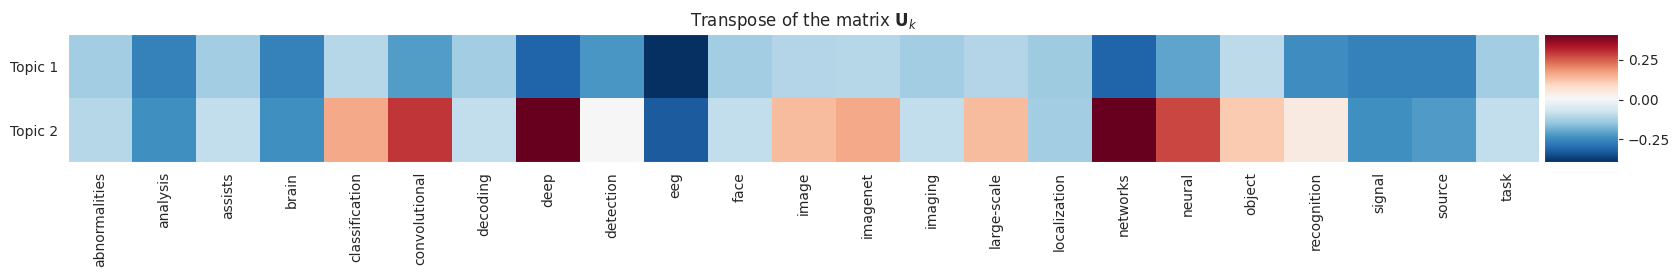

In [25]:
plt.figure(figsize=(20, 6))
ax = plt.gca()
im = plt.imshow(Uk.T, cmap=plt.cm.RdBu_r);
plt.grid(False)
plt.title('Transpose of the matrix $\mathbf{U}_k$')
plt.xticks(np.arange(0, vocab_size), vocabulary, rotation=90)
plt.yticks(np.arange(0, k), ['Topic %d' % (i+1) for i in range(k)])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


term_per_topic =5
for i, topic in enumerate(Uk.T):
    
    terms_topic = zip(vocabulary, topic)
    sorted_terms = sorted(terms_topic, key= lambda x:x[1], reverse=True)[:term_per_topic]
    
    print("Topic %d (latent dimension %i)" % (i+1, i+1))
    for t in sorted_terms:
        print('%20s (%3.2f)' % t)
    print('\n')

**1. The figure above shows the coefficient associated with each word for each topic. Which words are positively associated with topic 2 and which words are negatively associated with topic 2?**

ANSWER: This can be read quite triviially from the figure: convolutional, deep, networks, and neural are all positively associated with topic 2, as well as image, imagenet, object, recognition and large-scale. The rest are negatively associated

# Exercise 2: odd-one-out

### Solving odd-one-out puzzles using 8447 articles from the New York Times

As an example, find the 'odd-one-out' from the the list of four words: 'ship', 'car', 'plane', and 'orange'. 

Clearly, 'orange' is the odd one out here. In this exercise we will use latent semantic analysis to build a system to solve these puzzles automatically. 

Specifically, we will analyse 8447 articles from the News York Times (available here: https://github.com/moorissa/nmf_nyt), learn a latent semantic space and use that space to the solve odd-one-out puzzles.

First, we will load the data. The vocabulary list and the bag-of-words matrix are already prepared for us.

In [26]:
with open('nyt_data.txt') as f:
    documents = f.readlines()
documents = [x.strip().strip('\n').strip("'") for x in documents] 

# contains vocabs with rows as index
with open('nyt_vocab.dat') as f:
    vocabulary = f.readlines()
vocabulary = [x.strip().strip('\n').strip("'") for x in vocabulary] 

num_doc = 8447
vocab_size = 3012 
A = np.zeros([vocab_size,num_doc])

for col in range(len(documents)):
    for row in documents[col].split(','):
        A[int(row.split(':')[0])-1,col] = int(row.split(':')[1])

**1. Construct the term-by-term matrix $\mathbf{B} = \mathbf{A}\mathbf{A}^T$ and document-by-document $\mathbf{C} = \mathbf{A}^T \mathbf{A}$ and decompose them to eigenvalues and eigenvectors. This might take up to a few minutes.**

In [27]:
B = A@A.T
C = A.T@A

lambdas, U = eigendecompose(B)
print('Done decomposing B.')

lambdas, V = eigendecompose(C)
print('Done decomposing C.')

Done decomposing B.
Done decomposing C.


**2. Select the first $k$ dimensions and project the words that the $k$-dimensional latent space**

In [28]:
k = 20
Uk = U[:, :k]
Sk = lambdas[:k]
Vk = V[:, :k]

# define projection matrix for the words
P = Vk@np.diag(1./np.sqrt(Sk))

# project
z_word = A@P


Below is the list of odd-one-out puzzles that we want to solve using latent semantic analysis.

In [29]:
list_of_puzzles = [
                    ['ship', 'car', 'plane', 'orange'],
                    ['man', 'car', 'woman', 'person'],
                    ['sky', 'cup', 'glass', 'bowl'],
                    ['black', 'shoe', 'blue', 'red'],
                    ['basketball', 'coffee', 'water', 'milk'],
                    ['telephone', 'computer', 'dog', 'radio'],
                    ['president', 'door', 'minister', 'secretary'],
                    ['soccer', 'basketball', 'tennis', 'rain'],
                    ['photography', 'image', 'painting', 'airplane']
                    ]

The following code implements the odd-one-out solver.

**1. Study the function below and explain what it does.**

ANSWER: Bascially compares the co-occurences beteween different words, and finds the one least similar to all the others, as the odd one out. Orange, rarely occurs with plane, car and ship in our vocabulary.

**2. Add some puzzles of your own to the above list. Can you create puzzles that 'tricks' the solver?**

**3. $\star$Experiment with the number of latent dimensions k. How many dimensions do we need to solve this odd-one-out puzzles?**

In [30]:
def find_odd_one_out(puzzle):
    ''' the function takes a list of 4 words and 
        1. constructs a bag-of-words representation for each word
        2. projects them to the latent semantic space
        3. identifies the odd-one-out using cosine similaries
        4. returns the odd word '''
    
    # check if all words are present in vocab
    for word in puzzle:
        if word not in vocabulary:
            print('Word "%s" not found in vocabulary' % word)
    
    # construct bag-of-words representation
    q = construct_bag_of_words(puzzle, vocabulary)
    
    # compute project matrix
    P = np.diag(1./np.sqrt(Sk))@Uk.T

    # project to semantic space
    semantic_vectors = P@q

    # for each vector compute average cosine similarities to the three other concepts
    avg_sim = []
    for i in range(len(semantic_vectors.T)):

        # compute cosine similarities between i and the remaining three vectors
        cos_similarities = [cos_sim(semantic_vectors[:, i], semantic_vectors[:, j]) for j in range(len(semantic_vectors.T)) if i != j]

        # compute average and store
        avg_sim.append(np.mean(cos_similarities))
        
    # return the concept with lowest average cosine similarity
    return puzzle[np.argmin(avg_sim)]

#use the find_odd_one_out function to solve the puzzles
for puzzle in list_of_puzzles:
    
    odd_one = find_odd_one_out(puzzle)
    
    print('Concepts:', ', '.join(puzzle))
    print('Odd-one-out: %s' % odd_one)
    print('\n')

Concepts: ship, car, plane, orange
Odd-one-out: orange


Concepts: man, car, woman, person
Odd-one-out: car


Concepts: sky, cup, glass, bowl
Odd-one-out: sky


Concepts: black, shoe, blue, red
Odd-one-out: shoe


Concepts: basketball, coffee, water, milk
Odd-one-out: basketball


Concepts: telephone, computer, dog, radio
Odd-one-out: dog


Concepts: president, door, minister, secretary
Odd-one-out: door


Concepts: soccer, basketball, tennis, rain
Odd-one-out: rain


Concepts: photography, image, painting, airplane
Odd-one-out: airplane




## Exercise 3: Sentiment analysis of Amazon reviews

In the last part of the exercise, we will use sentiment analysis to Amazon product reviews. 

**The data (~250MB) can be downloaded from here: https://www.kaggle.com/snap/amazon-fine-food-reviews**

The goal is to predict whether the author of the review likes or dislikes the product he or she is reviewing.

First, we will load the data.

(You can see more details about the data here if you are interested: https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3)

In [32]:
df = pd.read_csv('Reviews.csv', usecols=['Text', 'Score'])

# Let's get rid of the neutral reviews
df.dropna(inplace=True)
df[df['Score'] != 3]

# .. and group negative reviews (rating = 1 or 2) together and group positive reviews (ratings = 4 or 5) together
df['Pos'] = np.where(df['Score'] > 3, 1, 0)

documents = df['Text'].tolist()
positives = df['Pos'].tolist()
num_doc = len(documents)

print('Number of documents: %d' % num_doc)

Number of documents: 568454


We have 568454 product reviews and each review has an associated score of either 0 or 1, where 0 means a negative review and 1 means a positive review.

**1. Start by preprocessing the text data. Convert all reviews to lower case and remove all punctuation (periods, commas, questionmarks and exclamation marks)**

In [33]:
documents_cleaned = []
for doc in documents:
    
    # to lower
    doc_cleaned = doc.lower()
    
    #doc_cleaned = ' '.join([word for word in doc_cleaned.split() if word not in stop_words])    
    doc_cleaned = doc_cleaned.replace('.', '')
    doc_cleaned = doc_cleaned.replace(',', '')
    doc_cleaned = doc_cleaned.replace('?', '')
    doc_cleaned = doc_cleaned.replace('!', '')
    documents_cleaned.append(doc_cleaned)


## 1: Sentiment analysis using lexicons

*Now we will load our sentiment lexicon. We will use Afinn created by Finn Nielsen (https://github.com/fnielsen/afinn)*

In [34]:
from afinn import Afinn
from collections import defaultdict
sent_lexicon = defaultdict(lambda: 0, Afinn()._dict)

/home/karl/Signals-And-Data-Autumn-2024/week_7/afinn/afinn.py:99: SyntaxWarning: invalid escape sequence '\w'
  self._word_pattern = re.compile('\w+', flags=re.UNICODE)


*Let's try to look up the sentiment scores for a few words:*

In [35]:
list_of_words = ['amazing', 'accept', 'hate', 'dislike', 'appreciate', 'stupid',  'love', 'like', 'enjoy', 'best', 'bad', 'worst', 'outstanding', 'food', 'politics', 'movie']

for word in list_of_words:
    if word in sent_lexicon:
        print('%-15s%+3.2f' % (word, sent_lexicon[word]))
    else:
        print('Word "%s" not found' % word)

amazing        +4.00
accept         +1.00
hate           -3.00
dislike        -2.00
appreciate     +2.00
stupid         -2.00
love           +3.00
like           +2.00
enjoy          +2.00
best           +3.00
bad            -3.00
worst          -3.00
outstanding    +5.00
Word "food" not found
Word "politics" not found
Word "movie" not found


*Let's check the number of words in the dictionary*

In [36]:
len(sent_lexicon)

3382

*.. and the range of the sentiment values is*

In [37]:
set(list(sent_lexicon.values()))

{-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5}

*That is, each word in the sentiment lexicon is associated with a score between -5 and 5.*

**1. Score the first review by looping through the words.**

In [38]:
index = 0
doc = documents_cleaned[index]
print('Sentence: %s\n' % doc)

print('Words           Sentiments')
print(26*'-')
sentiment = 0
for word in doc.lower().split():
    print('%-15s %3.2f' % (word, sent_lexicon[word]))
    sentiment += sent_lexicon[word]
        
print('\nOverall sentiment: %2.1f' % sentiment)


Sentence: i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most

Words           Sentiments
--------------------------
i               0.00
have            0.00
bought          0.00
several         0.00
of              0.00
the             0.00
vitality        3.00
canned          0.00
dog             0.00
food            0.00
products        0.00
and             0.00
have            0.00
found           0.00
them            0.00
all             0.00
to              0.00
be              0.00
of              0.00
good            3.00
quality         2.00
the             0.00
product         0.00
looks           0.00
more            0.00
like            2.00
a               0.00
stew            0.00
than            0.00
a               0.00
processed       0.00
meat            0.00
an

**2. $\star$ Discuss limitations: Can you think of any limitations of this approach?**
*Hint: Can you think of an example, where a single word changes the whole meaning of the review?*

## 2: Converting our sentiment lexicon into a vocabulary and a sentiment vector

**1. In order to use the tools we already have, convert the sentiment lexicon into a sentiment vocabulary and a sentiment vectors. This will allow us to compute sentiments as inner products between the bag of words representation and the sentiment vector**

In [39]:
sentiment_vocabulary = sent_lexicon.keys()
sentiment_vec = np.zeros((len(sentiment_vocabulary), 1))
for idx, word in enumerate(sentiment_vocabulary):
    sentiment_vec[idx, 0] = sent_lexicon[word]

*Using the bag of words representation, we can now compute sentiments using inner products*

In [40]:
q = construct_bag_of_words([doc], sentiment_vocabulary)
np.dot(q.T, sentiment_vec)

array([[16.]])

**2. Construct the bag of words representation for all 568411 reviews and compute the sentiments**

In [41]:
Qs = construct_bag_of_words(documents_cleaned, sentiment_vocabulary)
Qs.shape

(3415, 568454)

In [42]:
sentiments = sentiment_vec.T@Qs
sentiments.shape

(1, 568454)

**3. Can we predict the thresholded score of the reviews using our predicted sentiments?**

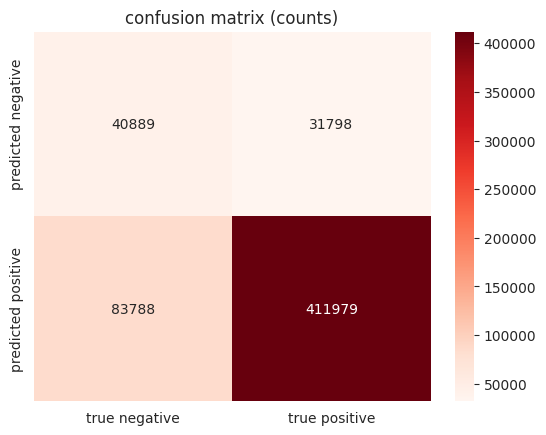

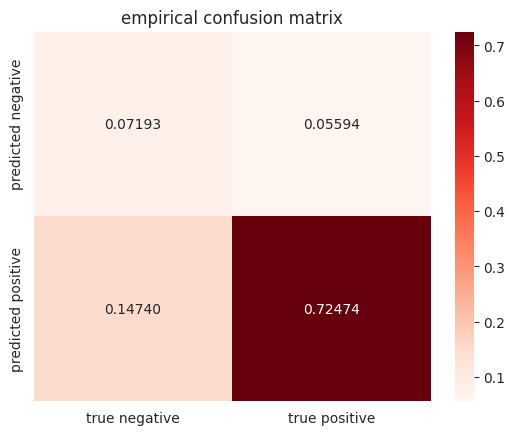

In [43]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(sentiments.ravel()>0,np.array(positives) > 0)

#compute and plot confusion matrix
snb.heatmap(CM,xticklabels=['true negative','true positive'],yticklabels=['predicted negative','predicted positive'],annot=True,cmap="Reds", fmt = 'd')
plt.title('confusion matrix (counts)')
plt.show()

#compute and plot normalized confusion matrix
CM_normalized = CM / CM.sum()
plt.title('empirical confusion matrix')
snb.heatmap(CM_normalized,xticklabels=['true negative','true positive'],yticklabels=['predicted negative','predicted positive'],annot=True,cmap="Reds",fmt=".5f")
plt.show();

**4. Inspect the confusion matrices above. How should the four numbers above be interpreted?**